The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.

In [5]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

Then we import the covid19_inference module.

In [6]:
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

We obtain the JHU data for the Netherlands.

In [7]:
jhu = cov19.data_retrieval.JHU()
jhu.download_confirmed()

# extract confirmed data
bd = datetime.datetime(2020,3,3) # when cases began to increase quickly
ed = datetime.date.today() - datetime.timedelta(days=1) # yesterday
total_cases = jhu.get_confirmed(country = "Netherlands", begin_date= bd, end_date = ed )

In [8]:
new_cases_obs = np.diff(total_cases.to_numpy().flatten())
print(new_cases_obs)

[  14   44   46   60   77   56   61  121    0  303  156  176  278  295
  347  409  536  637  577  547  816  858 1030 1179 1172 1111  887  850
 1029 1092 1033  906 1226  973  783  973 1221 1346 1322 1175  964  870
  736 1067 1236 1147 1072  750  729  715  889  808  655  656  400  172
  386  514  477  445]


For the choice of changing points, see https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_Netherlands

- 11/03 common changepoint for stricter measures in North Brabant 10/03 and for closure of schools and public events 12/03
-15/03 stricter measures
- 23/03 strict social distancing

All the parameters chosen in the following amount to a quick, naive application of the model to Netherlands. Delays are set as for Germany.

In [9]:
date_begin_data = bd
date_end_data   = ed
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 16

prior_date_brabant_closures = datetime.datetime(2020,3,11)
prior_date_stricter =  datetime.datetime(2020,3,15)
prior_date_social_distancing =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_transient = prior_date_brabant_closures,
                      pr_sigma_date_transient = 3, #reduced due to closeness to the next
                      pr_median_lambda = 0.3,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_stricter,
                      pr_sigma_date_transient = 3, #reduced
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_social_distancing,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1)]

In [10]:
params_model = dict(new_cases_obs = new_cases_obs[:],
                    data_begin = date_begin_data,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 17.3e6) 

# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.Cov19Model(**params_model) as model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    # Use this array to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, pr_median_mu=1/8)
    
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=10, 
                                               pr_median_scale_delay=0.4)
    # delay as for Germany
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)


INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5


In [11]:
trace = pm.sample(model=model, tune=500, draws=500, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 471.43:  11%|█         | 22399/200000 [00:42<05:40, 522.30it/s]
Convergence achieved at 22400
INFO     [pymc3.variational.inference] Convergence achieved at 22400
Interrupted at 22,399 [11%]: Average Loss = 545.64
INFO     [pymc3.variational.inference] Interrupted at 22,399 [11%]: Average Loss = 545.64
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor, delay_log, I_begin, mu, transient_len_3_log, transient_len_2_log, transient_len_1_log, transient_day_3, transient_day_2, transient_day_1, lambda_3_log, lambda_2_log, lambda_1_log, lambda_0_log]
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, weekend_factor, delay_log, I_begin, mu, transient_len_3_log, transient_len_2_log, trans

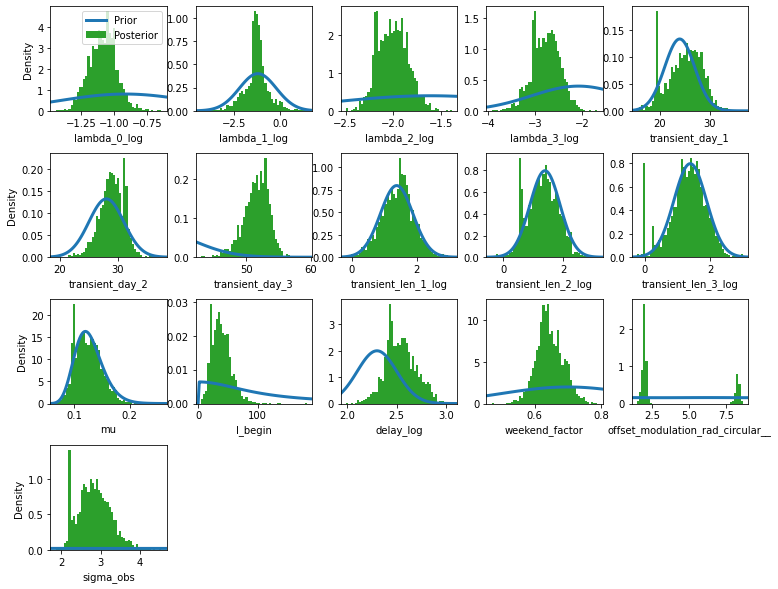

In [12]:
 varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)


Text(0, 0.5, 'Daily new cases')

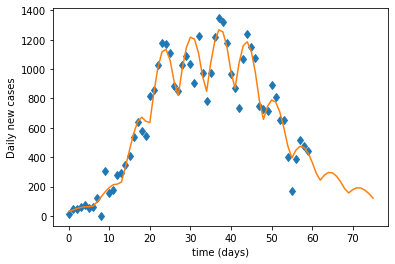

In [13]:
plt.plot(new_cases_obs, 'd')
plt.plot(np.median(trace.new_cases, axis=0))

plt.xlabel("time (days)")
plt.ylabel("Daily new cases")

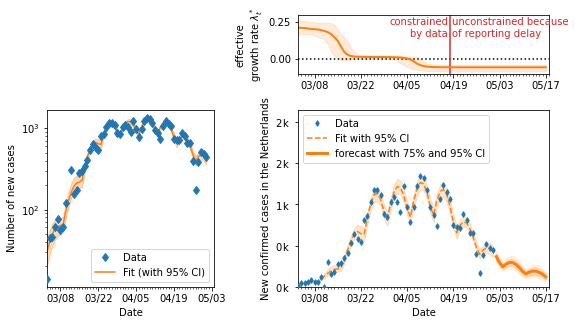

In [14]:
fig.subplots_adjust(wspace=0.25, hspace=0.4)
fig, axes = cov19.plotting.plot_cases(trace, new_cases_obs, bd - datetime.timedelta(days = diff_data_sim), diff_data_sim, country="the Netherlands")